# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpllimg
import seaborn as sns

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# Datas

In [4]:
# Load colums in dataframes for each dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

Train shape: (1790594, 17)
Test shape: (146853, 3)


In [5]:
# Info about datas
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790594 entries, 0 to 1790593
Data columns (total 17 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   StudyInstanceUID            object
 1   SeriesInstanceUID           object
 2   SOPInstanceUID              object
 3   pe_present_on_image         int64 
 4   negative_exam_for_pe        int64 
 5   qa_motion                   int64 
 6   qa_contrast                 int64 
 7   flow_artifact               int64 
 8   rv_lv_ratio_gte_1           int64 
 9   rv_lv_ratio_lt_1            int64 
 10  leftsided_pe                int64 
 11  chronic_pe                  int64 
 12  true_filling_defect_not_pe  int64 
 13  rightsided_pe               int64 
 14  acute_and_chronic_pe        int64 
 15  central_pe                  int64 
 16  indeterminate               int64 
dtypes: int64(14), object(3)
memory usage: 232.2+ MB


In [6]:
# Some examples 
df_train.head(n=10)

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0
5,6897fa9de148,2bfbb7fd2e8b,c7b99cb454d4,0,0,0,0,0,0,1,1,0,0,1,0,0,0
6,6897fa9de148,2bfbb7fd2e8b,e153deb813ed,0,0,0,0,0,0,1,1,0,0,1,0,0,0
7,6897fa9de148,2bfbb7fd2e8b,c6bbe08f2736,0,0,0,0,0,0,1,1,0,0,1,0,0,0
8,6897fa9de148,2bfbb7fd2e8b,09886998dc28,0,0,0,0,0,0,1,1,0,0,1,0,0,0
9,6897fa9de148,2bfbb7fd2e8b,5b5226ac7bac,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [7]:
# Pack dependant features in one categorical feature

# Merge 2 ratio features in a single one
ratio_mask = [x == 1 for x in df_train['rv_lv_ratio_gte_1']]
df_train['rv_lv_ratio'] = pd.Categorical(np.where(ratio_mask, ">=1", "<1"))

# Merge pe type related features in a signle one

# Take chronic and acute+chronic
def categorize_pe_type(data):
    if data['chronic_pe']: return "Chronic"
    elif data['acute_and_chronic_pe']: return "Acute and Chronic"
    else: return "Acute"
    
    
df_train['pe_type'] = pd.Categorical(df_train.apply(categorize_pe_type, axis=1))

In [8]:
# Remove packed features

# TODO add asserts to ensure a good behavior before dropping
df_train.drop(['rv_lv_ratio_gte_1','rv_lv_ratio_lt_1'], axis=1, inplace=True)
df_train.drop(['chronic_pe','acute_and_chronic_pe'], axis=1, inplace=True)

In [9]:
# Show dataframe's info with new features
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790594 entries, 0 to 1790593
Data columns (total 15 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   StudyInstanceUID            object  
 1   SeriesInstanceUID           object  
 2   SOPInstanceUID              object  
 3   pe_present_on_image         int64   
 4   negative_exam_for_pe        int64   
 5   qa_motion                   int64   
 6   qa_contrast                 int64   
 7   flow_artifact               int64   
 8   leftsided_pe                int64   
 9   true_filling_defect_not_pe  int64   
 10  rightsided_pe               int64   
 11  central_pe                  int64   
 12  indeterminate               int64   
 13  rv_lv_ratio                 category
 14  pe_type                     category
dtypes: category(2), int64(10), object(3)
memory usage: 181.0+ MB


In [10]:
# Show samples 
df_train.head(n=10)

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,leftsided_pe,true_filling_defect_not_pe,rightsided_pe,central_pe,indeterminate,rv_lv_ratio,pe_type
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,1,0,1,0,0,<1,Acute
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,1,0,1,0,0,<1,Acute
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,1,0,1,0,0,<1,Acute
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,1,0,1,0,0,<1,Acute
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,1,0,1,0,0,<1,Acute
5,6897fa9de148,2bfbb7fd2e8b,c7b99cb454d4,0,0,0,0,0,1,0,1,0,0,<1,Acute
6,6897fa9de148,2bfbb7fd2e8b,e153deb813ed,0,0,0,0,0,1,0,1,0,0,<1,Acute
7,6897fa9de148,2bfbb7fd2e8b,c6bbe08f2736,0,0,0,0,0,1,0,1,0,0,<1,Acute
8,6897fa9de148,2bfbb7fd2e8b,09886998dc28,0,0,0,0,0,1,0,1,0,0,<1,Acute
9,6897fa9de148,2bfbb7fd2e8b,5b5226ac7bac,0,0,0,0,0,1,0,1,0,0,<1,Acute


In [11]:
# Method to find features values of one image given its id
def imageFeatures(id):
    return df_train.loc[df_train['SOPInstanceUID'] == id]

In [12]:
# Builds the list of images IDs available in the given directory
def listAvailableImages(directory, extension):
    return list(map(lambda x: x.split(extension)[0], os.listdir(directory)))


available_images = listAvailableImages('images', '.jpg')

In [13]:
# Only keep available images rows
def cleanUpDataframe(df):
    return df.loc[df_train['SOPInstanceUID'].isin(available_images)]
    

df_train_clean = cleanUpDataframe(df_train)
df_train_clean

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,leftsided_pe,true_filling_defect_not_pe,rightsided_pe,central_pe,indeterminate,rv_lv_ratio,pe_type
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,1,0,1,0,0,<1,Acute
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,1,0,1,0,0,<1,Acute
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,1,0,1,0,0,<1,Acute
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,1,0,1,0,0,<1,Acute
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,1,0,1,0,0,<1,Acute
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88507,9934197d1d7d,16f3c3d9851d,9a899e0be9a6,0,1,0,0,0,0,0,0,0,0,<1,Acute
88508,9934197d1d7d,16f3c3d9851d,996873b9192b,0,1,0,0,0,0,0,0,0,0,<1,Acute
88509,9934197d1d7d,16f3c3d9851d,f3d335a3fd4e,0,1,0,0,0,0,0,0,0,0,<1,Acute
88510,9934197d1d7d,16f3c3d9851d,1144e3048221,0,1,0,0,0,0,0,0,0,0,<1,Acute


[0. 1. 2. 3. 4. 5. 6. 8.]


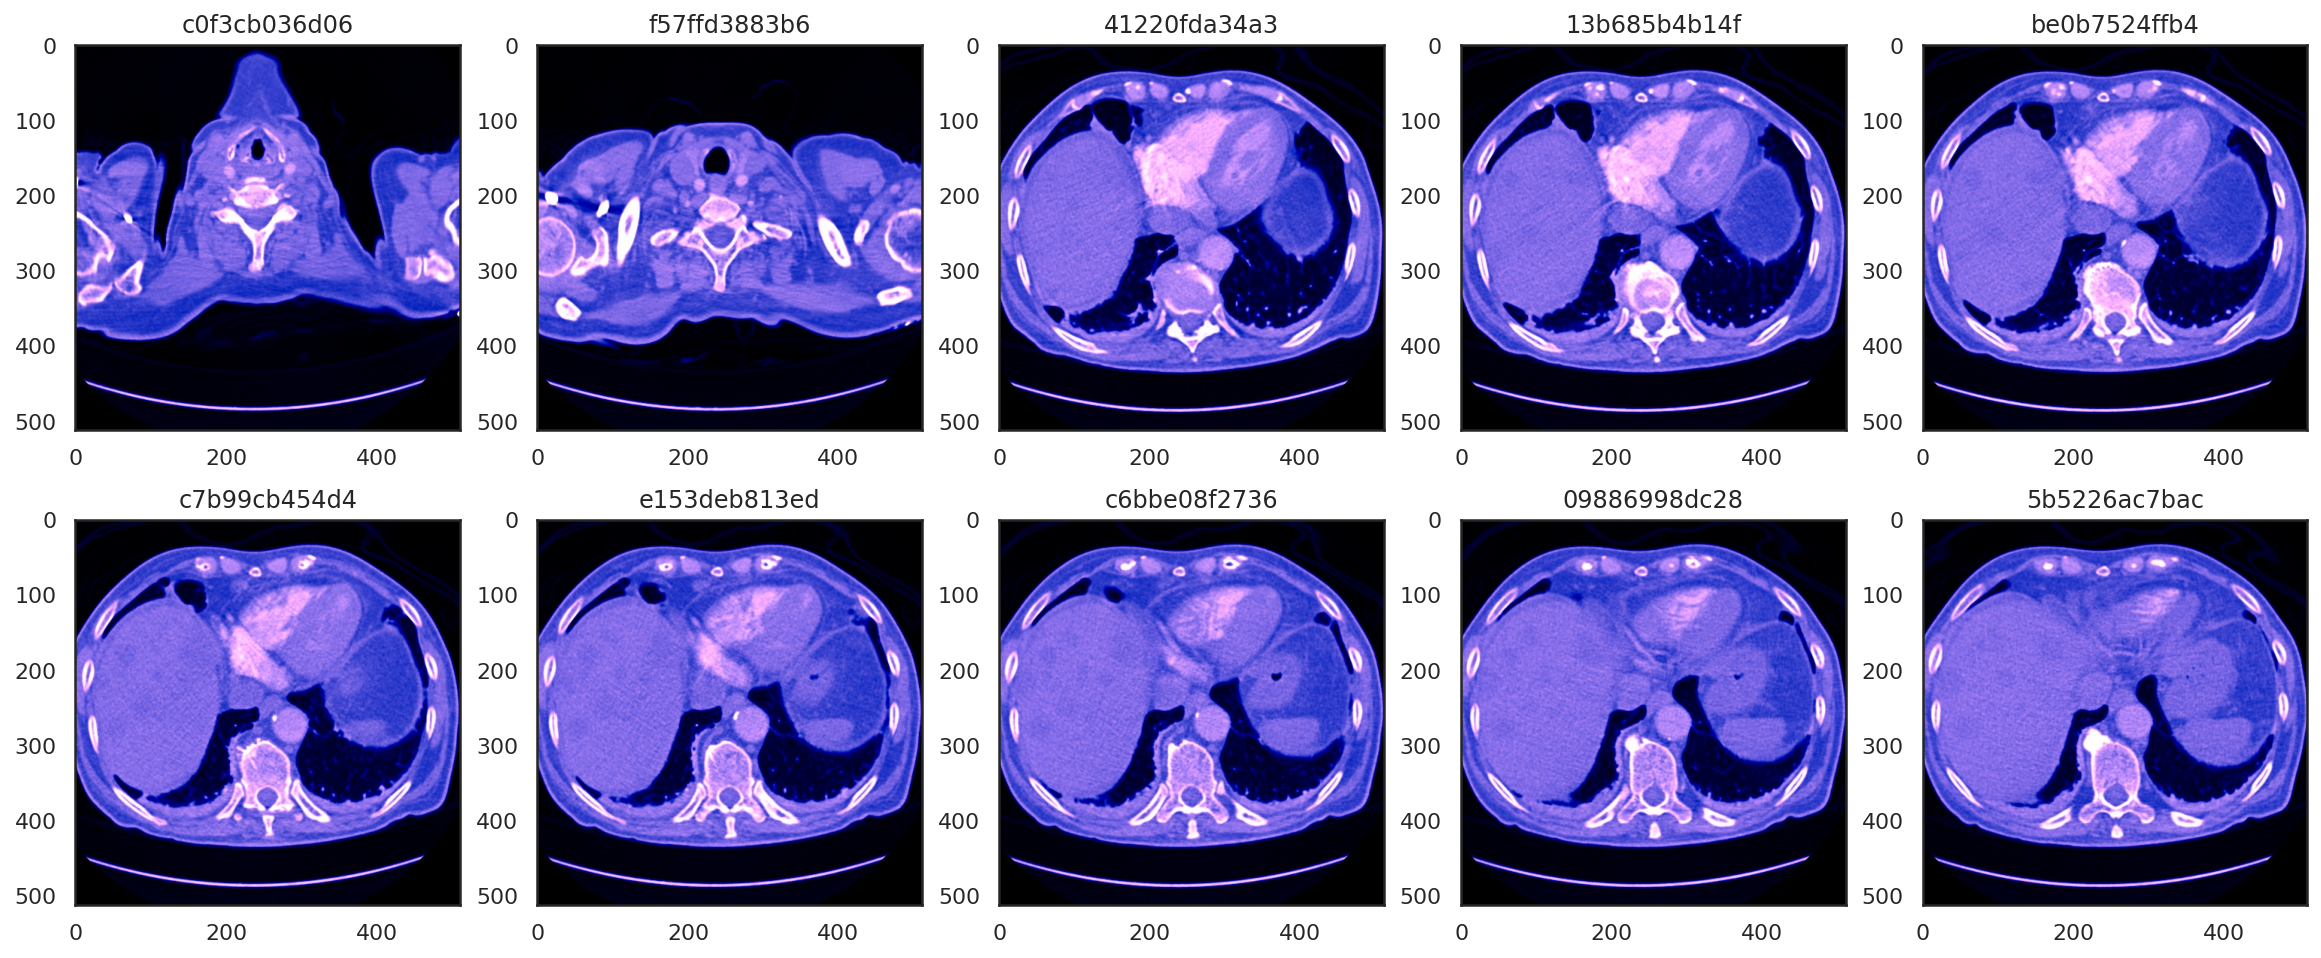

In [20]:
# Show the n first images of the dataset
def showHead(df, n=5):
    
    with sns.axes_style("white"): 
        plt.figure(figsize=(20, 8))
        for i, code in enumerate(df['SOPInstanceUID'][:n]):
            fig = plt.subplot(2, 5, i + 1)
            plt.imshow(mpllimg.imread('./images/' + code + '.jpg'), cmap=plt.cm.binary)
            plt.title(code)
        
        
showHead(df_train_clean, n=10)

In [32]:
im = plt.imread('./images/' + os.listdir('./images/')[0])

print(np.unique(im[:,:,0]))
print(np.unique(im[:,:,1]))
print(np.unique(im[:,:,2]))
print(np.unique(im))
print(im.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24